# Hybrid Feature Analyses SIM 2 - Detecting Pigs and the Swedish Chef

This notebook outlines the hybrid approach for the Similarity Modeling 2 project. It focuses on merging features extracted for both visual and audio classification to train a model capable of detecting the presence of the Pigs or the Swedish Chef in individual frames. To achieve this, we leverage the XGBoost algorithm, as introduced in the other files.
Due to computational resource constraints, the large number of features and easier model comparison, we exclusively employ the XGBoost Gradient Boosting algorithm for classification.


In [1]:
import pandas as pd
import numpy as np
from scripts.nested_cv import partition_feature_df

from scripts.load_data import check_and_load

# Load Features & Ground Truth

Video Features

In [2]:
video_features_path = "../model_vars/sim2_video/feature_df.csv"
video_feature_df = pd.read_csv(video_features_path)
video_feature_df = video_feature_df.drop(columns=['Pigs', 'Cook'])
video_feature_df.shape

(115885, 125)

Audio Features

In [3]:
audio_features_path = "../model_vars/sim2_audio/sim2_audio_features.csv"
audio_feature_df = pd.read_csv(audio_features_path)
audio_feature_df.shape

(115885, 64)

Merge feature dataframes

In [4]:
merged_feature_df = pd.merge(video_feature_df, audio_feature_df, on=['video_idx', 'frame_idx'], how='inner')
merged_feature_df.shape

(115885, 187)

Load Ground Truth

In [5]:
data_path = "../ground_truth_data"
frames_output_dir = "../ground_truth_data/frames"
audio_output_dir = "../ground_truth_data/audio"
annotations_path = "../ground_truth_data"

muppet_files = {
    "Muppets-02-01-01.avi": "GroundTruth_Muppets-02-01-01.csv",
    "Muppets-02-04-04.avi": "GroundTruth_Muppets-02-04-04.csv",
    "Muppets-03-04-03.avi": "GroundTruth_Muppets-03-04-03.csv",
}

annotations, audio_data, frames = check_and_load(data_path, frames_output_dir, audio_output_dir, annotations_path, muppet_files)

Frames and audio are already extracted.
Loading audio segments...
Loaded 3 audio files.
Loaded audio segments for 3 videos.
Loaded frames for 3 videos.
Number of videos with frames: 3
Video 0 has 38681 frames.
Video 1 has 38706 frames.
Video 2 has 38498 frames.


In [ ]:
video_idx_map = {filename: idx for idx, filename in enumerate(muppet_files.keys())}

ground_truth_data = []
for video_filename, annotation_df in annotations.items():
    video_idx = video_idx_map[video_filename] 
    for _, row in annotation_df.iterrows():
        ground_truth_data.append({
            'video_idx': video_idx,  
            'frame_idx': row['Frame_number'],  
            'Audio_Pigs': row['Audio_Pigs'],  
            'Audio_Cook': row['Audio_Cook'],  
            'Pigs': row['Pigs'], 
            'Cook': row['Cook'] 
        })

ground_truth_df = pd.DataFrame(ground_truth_data)
ground_truth_df.shape

(115885, 6)

We will create a combined target variable for the pigs and the swedish cook.

In [7]:
ground_truth_df['Pigs_combi'] = (
    (ground_truth_df['Audio_Pigs'] == 1) | 
    (ground_truth_df['Pigs'] == 1)
).astype(int)

ground_truth_df['Cook_combi'] = (
    (ground_truth_df['Audio_Cook'] == 1) | 
    (ground_truth_df['Cook'] == 1)
).astype(int)

ground_truth_df = ground_truth_df.drop(columns=['Pigs', 'Audio_Pigs', 'Cook', 'Audio_Cook'])
ground_truth_df.head()

,video_idx,frame_idx,Pigs_combi,Cook_combi
0,0,0,0,0
1,0,1,0,0
2,0,2,0,0
3,0,3,0,0
4,0,4,0,0


Merge the ground truth and the feature dataframe

In [ ]:
feature_df = pd.merge(merged_feature_df, ground_truth_df, on=['video_idx', 'frame_idx'], how='inner')
feature_df.shape

(115885, 189)

Create Partitions

In [9]:
# split_points = {
#     0: 19716,  # Video 0
#     1: 19719,  # Video 1
#     2: 19432, # Video 2 
# }

grp_by = ['Pigs_combi', 'Cook_combi']
feature_df, split_overview = partition_feature_df(feature_df, grp_by = grp_by)

feature_df.shape

print(split_overview)

feature_df['fold'].unique() # ACHTUNG manche fehlen in den Splits!

   video_idx fold  Pigs_combi  Cook_combi
0          0  0-A        1871         217
1          0  0-B           0        1654
2          1  1-A        4074         226
3          1  1-B        4769           0
4          2  2-A        5158         683
5          2  2-B        5729         665


array(['0-A', '0-B', '1-A', '1-B', '2-A', '2-B'], dtype=object)

Check for Inf, NA etc.

In [10]:
numeric_df = feature_df.select_dtypes(include=[np.number])

print("NaN in any feature:", feature_df.isnull().values.any())
print("Inf in any numeric feature:", np.isinf(numeric_df.values).any())
rows_with_inf = numeric_df[np.isinf(numeric_df).any(axis=1)].index.tolist()
print("Rows with Inf values:", rows_with_inf)

NaN in any feature: True
Inf in any numeric feature: False
Rows with Inf values: []


# Hybrid Classification

In [11]:
from scripts.nested_cv import evaluate_model, nested_cross_validation, ncv_xgb_gpu

In [12]:
train_cols = feature_df.drop(columns=[
    'fold', 
'video_idx',
'frame_idx',
'Unnamed: 0',
'Cook_combi',
'Pigs_combi']).columns

train_cols.to_series().to_csv('../model_vars/sim2_hybrid/train_cols.csv', index=False, header=False)

## Train-Test-Split Approach

In this analysis, we employ a nested cross-validation approach for our classification models. The nested cross-validation provides robust model evaluation by incorporating two levels of data splitting: an outer loop for testing model generalization and an inner loop for hyperparameter tuning. The outer loop ensures that the performance metrics reflect how well the model generalizes to entirely unseen data, while the inner loop systematically optimizes the model's parameters using the training data.

A traditional random train-test split could lead to data leakage if frames from the same video appear in both the training and testing sets. This overlap could inflate performance metrics by allowing the model to learn video-specific features rather than generalizable patterns. The nested cross-validation mitigates this risk by ensuring that the outer splits isolate data from different videos, providing a more realistic estimate of the model's ability to generalize across unseen scenarios. 

For the creation of the folds, each episode is split at its midway point, specifically at the transition where a segment ends and the screen briefly fades to black before the next segment begins. This results in two distinct folds per episode, ensuring that each fold captures a separate and coherent part of the episode.

## XGBoost

In [63]:
import torch
from scripts.nested_cv import ncv_xgb_gpu

if torch.cuda.is_available():
    print(f"CUDA is available. GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")


CUDA is available. GPU: NVIDIA GeForce RTX 4070 Ti SUPER


### Pigs

In [64]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}

feature_df_pigs = feature_df[feature_df['fold'] != "0-B"]
feature_df_pigs.shape

target_col='Pigs_combi'
results_xgb_pigs, summary_xgb_pigs, best_models_xgb_pigs = ncv_xgb_gpu(
    feature_df=feature_df_pigs,
    train_cols=train_cols,
    target_col=target_col,
    param_grid=param_grid
)


## Save Vars
import pickle
with open('../model_vars/sim2_hybrid/pigs_xgb_results.pkl', 'wb') as f:
    pickle.dump({
        'results_pigs': results_xgb_pigs,
        'summary_pigs': summary_xgb_pigs,
        'best_model_pigs': best_models_xgb_pigs
    }, f)

Outer Fold: 0-A
Outer Fold: 1-A
Outer Fold: 1-B
Outer Fold: 2-A
Outer Fold: 2-B
Model: 6/6
Summary of Metrics Across Folds:
{'accuracy': 0.7592021232867425, 'precision': 0.3949690375769248, 'recall': 0.13616410400717333, 'f1': 0.18884274123641348, 'roc_auc': 0.6679547115474355}


### Swedish Cook

In [65]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}

feature_df_cook = feature_df[feature_df['fold'] != "1-B"]
feature_df_cook.shape

target_col='Cook_combi'
results_xgb_cook, summary_xgb_cook, best_models_xgb_cook = ncv_xgb_gpu(
    feature_df=feature_df_cook,
    train_cols=train_cols,
    target_col=target_col,
    param_grid=param_grid
)


## Save Vars
import pickle
with open('../model_vars/sim2_hybrid/cook_xgb_results.pkl', 'wb') as f:
    pickle.dump({
        'results_cook': results_xgb_cook,
        'summary_cook': summary_xgb_cook,
        'best_model_cook': best_models_xgb_cook
    }, f)

Outer Fold: 0-A
Outer Fold: 0-B
Outer Fold: 1-A
Outer Fold: 2-A
Outer Fold: 2-B
Model: 6/6
Summary of Metrics Across Folds:
{'accuracy': 0.9636132482943106, 'precision': 0.4813457315448377, 'recall': 0.3760702975302551, 'f1': 0.37722257116114327, 'roc_auc': 0.7718571596050887}


## Evaluation

In [13]:
import pickle
import pandas as pd

with open('../model_vars/sim2_hybrid/pigs_xgb_results.pkl', 'rb') as f:
    pigs_data = pickle.load(f)
    results_xgb_pigs = pigs_data['results_pigs']
    summary_xgb_pigs = pigs_data['summary_pigs']
    best_models_xgb_pigs = pigs_data['best_model_pigs']

with open('../model_vars/sim2_hybrid/cook_xgb_results.pkl', 'rb') as f:
    cook_data = pickle.load(f)
    results_xgb_cook = cook_data['results_cook']
    summary_xgb_cook = cook_data['summary_cook']
    best_model_xgb_cook = cook_data['best_model_cook']

#### Pigs

In [14]:
results_xgb_pigs

,outer_fold,accuracy,precision,recall,f1,roc_auc
0,0-A,0.866504,0.199684,0.135222,0.161249,0.636110
1,1-A,0.729246,0.293098,0.219931,0.251297,0.747539
2,1-B,0.796229,0.975687,0.193542,0.323010,0.761168
3,2-A,0.731525,0.478853,0.129508,0.203876,0.672167
4,2-B,0.672506,0.027523,0.002618,0.004782,0.522790


Fold 1-B Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     14218
           1       0.98      0.19      0.32      4769

    accuracy                           0.80     18987
   macro avg       0.88      0.60      0.60     18987
weighted avg       0.83      0.80      0.74     18987



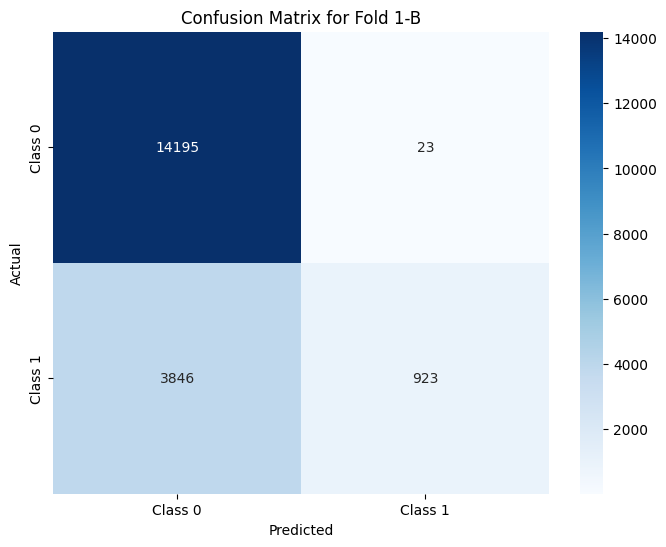

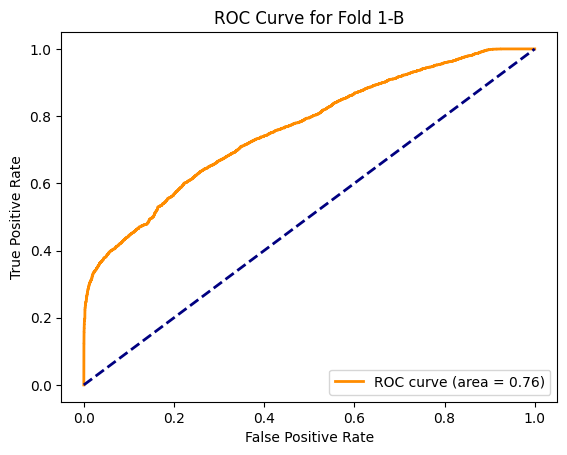

In [15]:
evaluate_model(best_models_xgb_pigs, feature_df, train_cols, 'Pigs_combi', results_xgb_pigs, spec_fold= "best")

Fold 2-B Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.96      0.80     13337
           1       0.03      0.00      0.00      5729

    accuracy                           0.67     19066
   macro avg       0.36      0.48      0.40     19066
weighted avg       0.49      0.67      0.56     19066



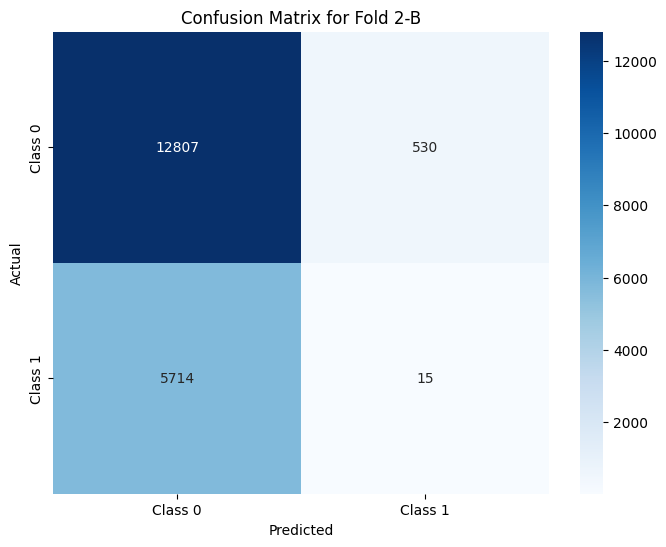

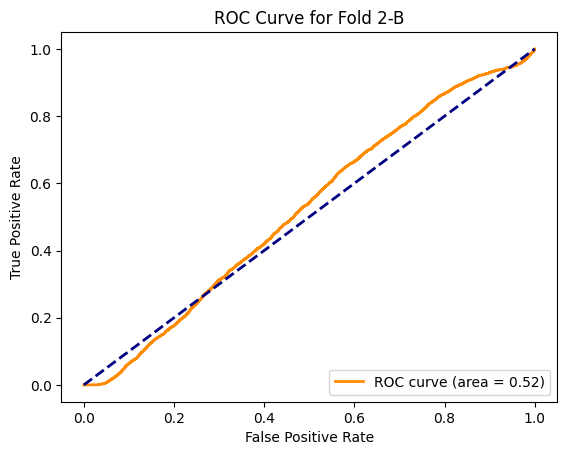

In [16]:
evaluate_model(best_models_xgb_pigs, feature_df, train_cols, 'Pigs_combi', results_xgb_pigs, spec_fold= "worst")

#### Swedish Cook

In [33]:
results_xgb_cook

,outer_fold,accuracy,precision,recall,f1,roc_auc
0,0-A,0.997160,0.954802,0.778802,0.857868,0.999722
1,0-B,0.912787,NaN,0.000000,0.000000,0.463648
2,1-A,0.994624,0.718978,0.871681,0.788000,0.992567
3,2-A,0.948899,0.251603,0.229868,0.240245,0.686951
4,2-B,0.964597,0.000000,0.000000,0.000000,0.716397


Fold 0-A Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19499
           1       0.95      0.78      0.86       217

    accuracy                           1.00     19716
   macro avg       0.98      0.89      0.93     19716
weighted avg       1.00      1.00      1.00     19716



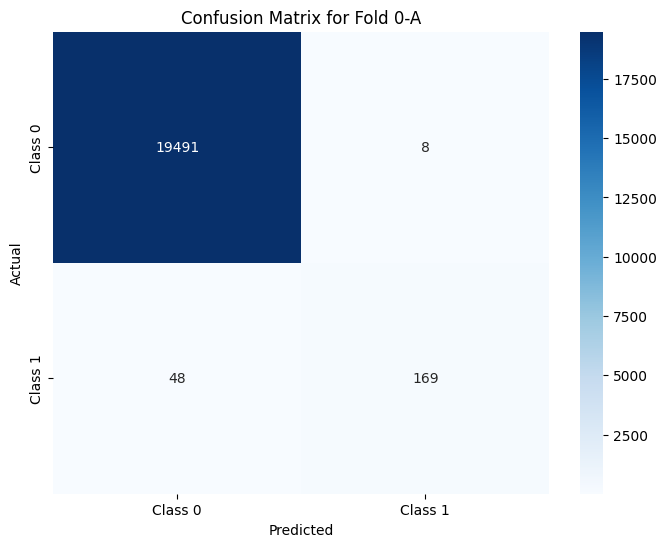

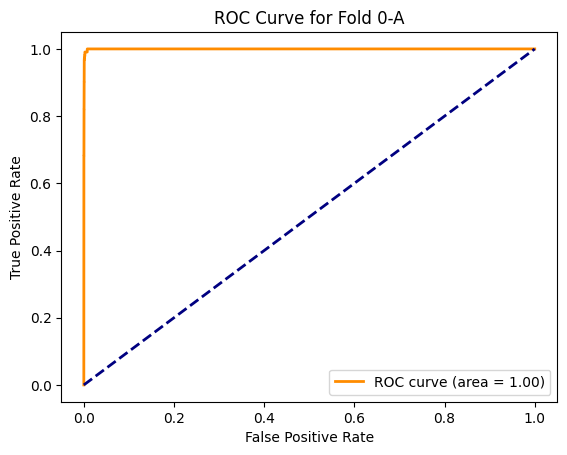

In [71]:
evaluate_model(best_model_xgb_cook, feature_df, train_cols, 'Cook_combi', results_xgb_cook, spec_fold= "best")

Fold 0-B Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     17311
           1       0.00      0.00      0.00      1654

    accuracy                           0.91     18965
   macro avg       0.46      0.50      0.48     18965
weighted avg       0.83      0.91      0.87     18965



c:\Users\Mocca\anaconda3\envs\sim1_2\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Mocca\anaconda3\envs\sim1_2\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Mocca\anaconda3\envs\sim1_2\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


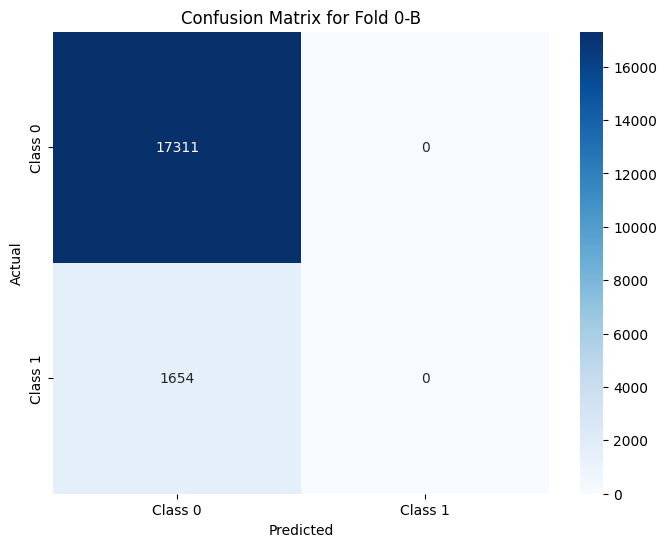

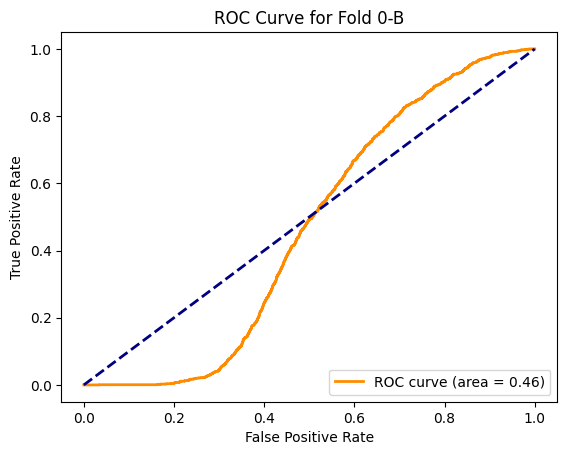

In [72]:
evaluate_model(best_model_xgb_cook, feature_df, train_cols, 'Cook_combi', results_xgb_cook, spec_fold= "worst")

### Feature Importance

<Figure size 1200x800 with 0 Axes>

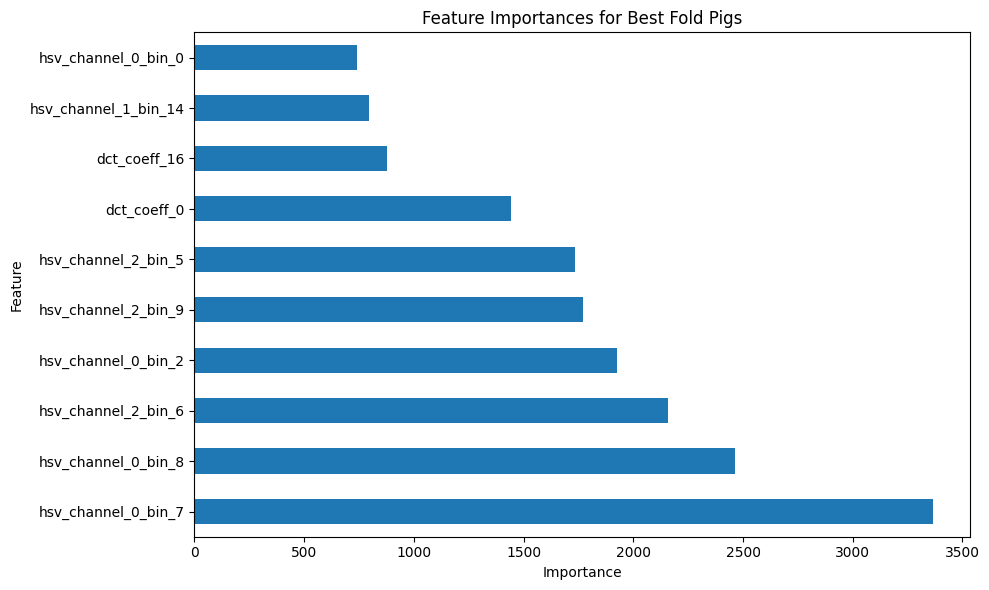

<Figure size 1200x800 with 0 Axes>

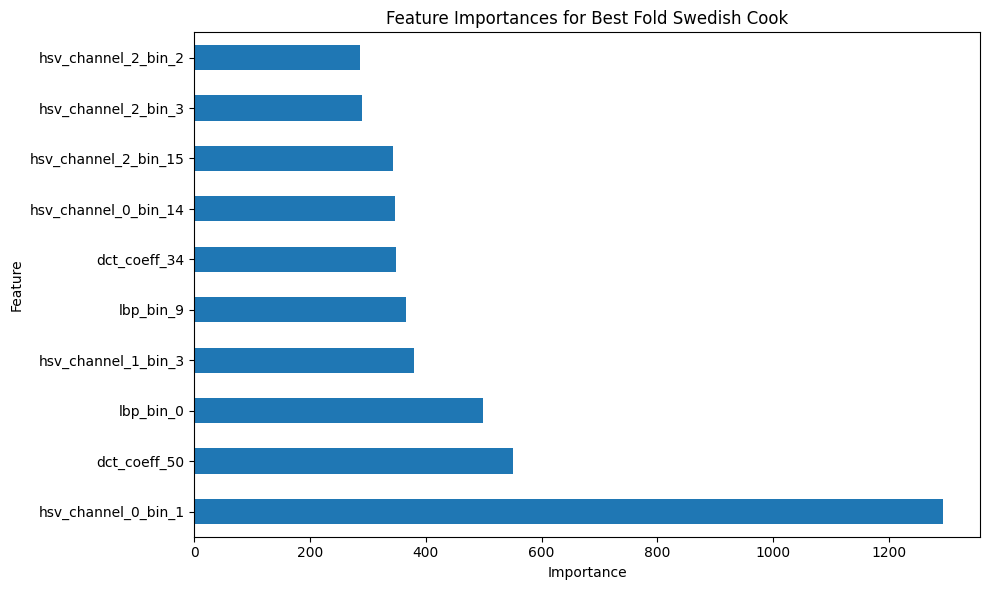

In [73]:
from scripts.nested_cv import plot_feature_importances 

# Pigs
plot_feature_importances(best_models_xgb_pigs, feature_df, train_cols, results_xgb_pigs, name= "Pigs", n= 10)

# Cook
plot_feature_importances(best_model_xgb_cook, feature_df, train_cols, results_xgb_cook, name= "Swedish Cook", n= 10)

## Conclusion

Similar to Similarity Modeling 1, the best and worst folds for both the Pigs and the Swedish Chef remain consistent when compared to visual classification. A direct comparison with the audio models is challenging, as missing annotations for the cook in a lot folds made it impossible to use our classification approach.

For the Pigs, the inclusion of audio features marginally improves the prediction of the minority class compared to the visual model. Across the folds, we observe reduced variability. However, for the worst-performing fold, despite an improved AUC, the precision decreases. As with Kermit, color features dominate the top 10 feature importance rankings, likely due to the distinctive pink color of the pigs.


| **Results Pigs - XGBoost**  | **Accuracy** | **Precision** | **Recall** | **F1**    | **ROC AUC** |
|-----------------------------|--------------|---------------|------------|-----------|-------------|
| **Audio - Overall**         | 0.9350       | 0.3381        | 0.0138     | 0.0220    | 0.6835      |
| **Visual - Overall**        | 0.7551       | 0.3932        | 0.1397     | 0.1906    | 0.6606      |
| **Hybrid - Overall**        | 0.7592       | 0.3950        | 0.1362     | 0.1888    | 0.6680      |
| **Audio - Best Fold\***       | 0.8827       | 0.7067        | 0.0234     | 0.0453    | 0.7012      |
| **Visual - Best Fold**      | 0.9410       | 0.8106        | 0.7284     | 0.7673    | 0.9744      |
| **Hybrid - Best Fold**      | 0.7962       | 0.9757        | 0.1935     | 0.3230    | 0.7612      |

\* Best Precision and Recall

For the Swedish Chef, the best and worst folds also remain unchanged compared to the visual model. The addition of audio features slightly worsens the prediction of the minority class, while the AUC for the best fold remains unchanged. However, the overall AUC across all folds declines. Here too, the top 10 most important features are dominated by visual features, emphasizing their critical role in classification.

| **Results Cook- XGBoost**  | **Accuracy** | **Precision** | **Recall** | **F1**    | **ROC AUC** |
|----------------------------|--------------|---------------|------------|-----------|-------------|
| **Visual - Overall**       | 0.9638       | 0.4812        | 0.3904     | 0.3852    | 0.8128      |
| **Hybrid - Overall**       | 0.9636       | 0.4813        | 0.3761     | 0.3772    | 0.7719      |
| **Visual - Best Fold**     | 0.9977       | 0.9479        | 0.8387     | 0.8900    | 0.9997      |
| **Hybrid - Best Fold**     | 0.9972       | 0.9548        | 0.7788     | 0.8579    | 0.9997      |

